In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

asdasd

In [3]:

df=pd.read_csv("https://raw.githubusercontent.com/ShirishChinch/Cs419M/main/ratings_small.csv")



Visualisation of Data


In [4]:
users_list = len(df["userId"].unique())

movies_list = len(df["movieId"].unique())


Plotting Number of movies rated by users

Text(0, 0.5, 'Count of users')

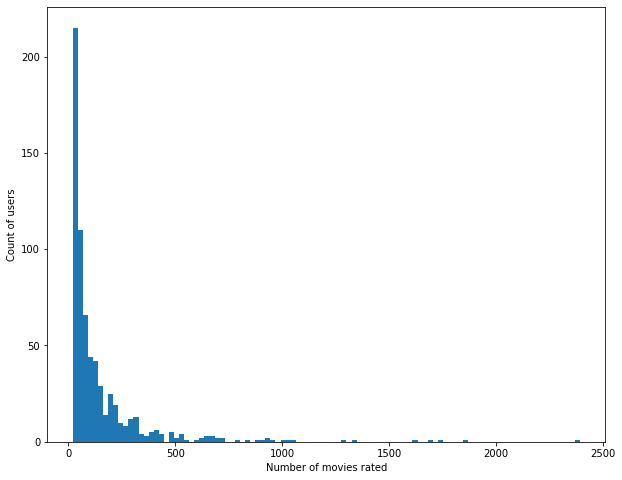

In [5]:
userscount= df["userId"].value_counts()
plt.figure(figsize = (10,8))
plt.hist(userscount,bins = 100)
#We choose 100 bins
#plt.legend
plt.xlabel("Number of movies rated")
plt.ylabel("Count of users")

Plotting number of users which rated for a given movie

Text(0, 0.5, 'Number of Ratings for a movie')

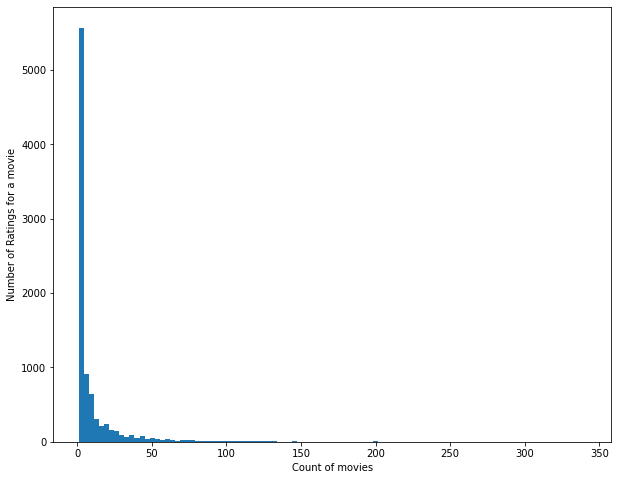

In [6]:
moviescount= df["movieId"].value_counts()
plt.figure(figsize = (10,8))
plt.hist(moviescount,bins = 100)
#We choose 100 bins
#plt.legend
plt.xlabel("Count of movies")
plt.ylabel("Number of Ratings for a movie")

Plotting Ratings vs Count

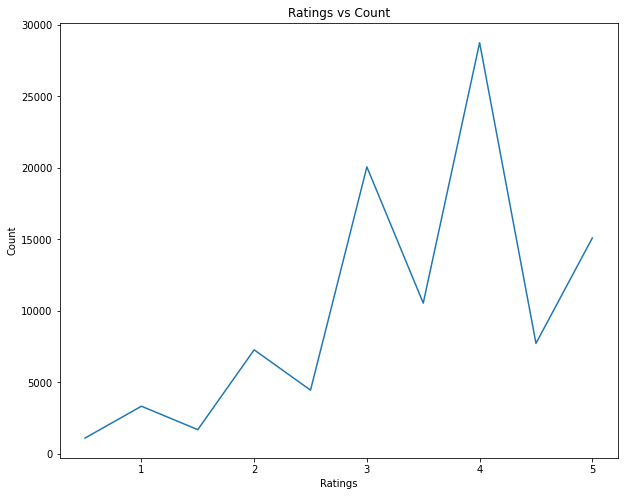

In [7]:
rating = df["rating"].value_counts().sort_index()

plt.figure(figsize = (10,8))
plt.plot(rating.index,rating.values);
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Ratings vs Count");

In this most of the users gave a 4 star rating as can be seen.
A lot of users have rated 3 or 5 so we have sufficient data for each rating.
Since some users have rated low number of movies, we dont have ample data on the user to make a prediction.
Also some movies have less people count so there might be a chance for bias and hance we remove such cases which have insufficient data.


So now, we will set a threshold on our movie ratings and user ratings and filter out those movies which have been rated less and those users which have been rated less. Since we will be proceeding with user - user based similarity in designing the algorithm from scratch, we will keep a stricter threshold for minimum user ratings (150). For minimum movie ratings, we dont want to be losing too much information so we keep the threshold at 100

In [8]:
movierating = 100
filteredmovies = df['movieId'].value_counts() > movierating
filteredmovies = filteredmovies[filteredmovies].index.tolist()

min_user_ratings = 150
filter_users = df['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['movieId'].isin(filteredmovies)) & (df['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100004, 4)
The new data frame shape:	(12454, 4)


In [9]:
usersnew = len(df_new["userId"].unique())
print("New number of users are ", usersnew)

moviesnew = len(df_new["movieId"].unique())
print("The number of movies are",moviesnew)

New number of users are  179
The number of movies are 149


In [10]:
df_train, df_test = train_test_split(df_new, test_size=0.3, random_state=42)
print("The entries in train set are",df_train.shape[0])
print("the entries in test set are ",df_test.shape[0])

The entries in train set are 8717
the entries in test set are  3737


User-user collaborative filtering will be used for this purpose. Let us now define the pearson correlation which will calculate the similarity between two users. After calculating the similarity, we will recommend movies to the user which have been rated highly by the other users having similar interests.

The pearsons correlation is given by
covariance(X, Y) / (stdv(X) * stdv(Y))

We will have to write a custom Pearsons coefficient since we only calculate for the movies common to a specific pair

In [11]:
from scipy.stats import pearsonr
def pearson_coeff(i,j):
  #filter out the dataset of a particular user
  useri = df_train[df_train["userId"] == i]
  userj = df_train[df_train["userId"] == j]

  #merge the two datasets with movieId as the column, this will give us the common movies rated
  mergedStuff = pd.merge(useri, userj, on=['movieId'], how='inner')
  
  #corr, _ = pearsonr(mergedStuff['rating_x'],mergedStuff['rating_y'])
  #print(corr)
  #take the mean of ratings given by both the users to all the movies
  meani = df_train[df_train["userId"] == i]["rating"].mean()
  meanj = df_train[df_train["userId"] == j]["rating"].mean()
  
  #calculate the pearson correlation
  num = ((mergedStuff['rating_x']-meani)*(mergedStuff['rating_y']-meanj)).sum()
  dem1 = ((mergedStuff['rating_x']-meani)**2).sum()
  dem2 = ((mergedStuff['rating_y']-meanj)**2).sum()
  
  result = num/np.sqrt(dem1*dem2)
  ###if they dont have any common movies rated, assume the users have the least similarity and assign -1
  if math.isnan(num/np.sqrt(dem1*dem2)):
    result = -1
  return result
 

Now we will store the list of users and movies in arrays so that these can be used to calculate the similarity matrix

In [12]:
user_list = df_train["userId"].unique()
user_list_sort = user_list.sort()
movie_list = df_train["movieId"].unique()
print(user_list)
print(len(user_list))
p_coeff = np.zeros((700,700))
for i in user_list:
  for j in user_list:
      p_coeff[i-1][j-1] = pearson_coeff(i,j)

[  4  15  17  19  21  22  23  26  30  34  41  48  56  57  61  72  73  77
  78  81  83  86  88  93  94  95  99 102 105 111 118 119 125 128 130 133
 134 149 150 152 157 165 176 177 185 187 189 195 199 200 205 212 213 214
 220 232 235 236 239 240 242 243 247 250 253 262 265 268 270 275 283 285
 287 292 294 295 299 303 306 311 312 313 324 328 342 344 345 346 350 353
 355 358 363 367 371 373 380 382 384 387 388 390 394 402 405 407 408 412
 418 423 426 427 428 430 431 433 434 439 442 452 457 460 461 463 466 468
 471 472 475 480 481 487 500 501 505 509 510 514 518 519 520 522 529 533
 534 537 544 547 553 558 561 562 563 564 574 575 577 580 584 585 587 595
 596 597 598 599 605 607 608 615 620 624 627 646 648 652 654 664 665]
179


In [13]:
def prediction(uid, mid):
  #we will chose 50 nearest neighbours, and take the weighted mean of the movie ratings with weights as similarity coefficients 
  arr = p_coeff[uid - 1] #this is to take the similarity row of the user with all the other users
  #note that we have to subtract 1 since indexing in the similarity matrix p coeff starts from 1
  sim = arr
  arr_copy = arr
  k_neighb = arr_copy.argsort()[-50:][::-1] #find the 50 nearest neighbours (list of users)
  
#now if the each neighbour in the 50 neighbours have rated the movie, we will take the weighted mean and generate the predicted rating
  num = 0
  dem = 0
  count = 0
  #Now we loop over the 50 nearest neighbours
  for i in k_neighb.flatten():
    movies = df_train[df_train["userId"] == i + 1]["movieId"].unique() #add 1 to the index, this will give the list of movies the user has rated
    #if the user has rated the movie, take the weighted average
    if mid in movies:
      #extract the rating given by the user
      b = df_train[df_train["userId"] == i + 1]
      a = b[b["movieId"] == mid]["rating"].iloc[0]
      
      num += sim[i]*a
      dem += sim[i]
      
      count += 1
  if(dem==0):
    result = random.randint(1,5)
  else:  
    result = num/dem
  #For nan case
  #if math.isnan(num/dem):
  #  result = random.randint(1,5)

  return(result)

In [14]:
df_test


,userId,movieId,rating,timestamp
3676,21,780,3.0,853157476
2803,17,1721,0.5,1127472770
71171,500,367,1.5,1228920944
12385,78,589,5.0,1274050763
82670,563,296,5.0,1378623670
...,...,...,...,...
58577,426,6874,4.0,1214633654
41277,295,4995,4.5,1112545204
50374,371,293,4.0,1462734440
48782,358,153,2.0,957534758


We now make the predictions. We will store the results in predict array and the error in the error array and then calculate the rmse error

In [15]:
results = []
error = []
for lines in df_test.itertuples():
  predict = prediction(lines[1],lines[2])
  results.append(predict)
  error.append(predict - lines[3])



In [16]:
error_arr = np.array(error)
np.sqrt((error_arr**2).sum()/df_test.shape[0])

0.8876437216368023

In [24]:
prediction(1, 1036)
print(df.shape)
print(df.head)
def recommend_movies_user_user(user,df):
    progress = 0
    ratings = []
    all_movies = df["movieId"]
    user_watched_movies = df.query("userId =="+str(user))["movieId"]
    for current_movie in all_movies:
        if current_movie not in user_watched_movies:
            rating = prediction(user,current_movie)
            progress +=1
            if not math.isnan(rating):
                ratings.append({"movieId":current_movie,"rating":rating})
                print(rating)
                print(str(((progress+1)/(len(all_movies)-len(user_watched_movies)))*100)+"%")
    ratings = sorted(ratings, key = lambda i:i["rating"],reverse=True)
    return ratings[0:10]
print(recommend_movies_user_user(1,df[:5000]))   

Streaming output truncated to the last 5000 lines.
49.27710843373494%
4
49.29718875502008%
5
49.31726907630522%
3
49.337349397590366%
4
49.3574297188755%
1
49.377510040160644%
1
49.39759036144578%
3
49.41767068273092%
2
49.437751004016064%
2
49.45783132530121%
1
49.47791164658635%
2
49.497991967871485%
3
49.51807228915663%
3
49.53815261044176%
2
49.558232931726906%
4
49.57831325301205%
5
49.59839357429719%
3
49.618473895582326%
3
49.63855421686747%
4
49.65863453815261%
2
49.67871485943775%
2
49.6987951807229%
1
49.71887550200803%
4
49.738955823293175%
4
49.75903614457831%
1
49.77911646586345%
3
49.79919678714859%
2
49.81927710843374%
5
49.83935742971888%
2
49.859437751004016%
2
49.87951807228916%
4
49.899598393574294%
1
49.91967871485944%
2
49.93975903614458%
3
49.95983935742972%
3
49.97991967871486%
2
50.0%
3
50.02008032128514%
2
50.040160642570285%
1
50.06024096385542%
1
50.08032128514056%
1
50.100401606425706%
5
50.12048192771085%
3
50.14056224899598%
5
50.16064257028112%
3
50.18072

Now we try the item-item filtering way for prediction instead of user-user. 

In [27]:
import numpy as np
import pandas as pd
import math

df = pd.read_csv("https://raw.githubusercontent.com/ShirishChinch/Cs419M/main/ratings_small.csv")
df = pd.DataFrame(df)
df = df.drop_duplicates()

movie_data = {}

for i in range(len(df["userId"])):
    if df["movieId"][i] not in movie_data.keys():
        movie_data[df["movieId"][i]] = np.zeros(len(df.userId.unique()))         
        movie_data[df["movieId"][i]][df["userId"][i]-1] = df["rating"][i]
    else:
        movie_data[df["movieId"][i]][df["userId"][i]-1] = df["rating"][i]

def get_rating(user,movieId,df,movie_data):
    nearest_neighbors = 10
    movieId = movieId
    simmilarity_factor = []

    for i in movie_data.keys():
        val = movie_data[movieId].dot(movie_data[i])/(np.linalg.norm(movie_data[movieId])*np.linalg.norm(movie_data[i]))
        simmilarity_factor.append({"movie":i,"simmilarity":val})

    ordered_simmilarity_factor = sorted(simmilarity_factor,key = lambda i:i["simmilarity"],reverse = True ) 
    nearest_neighbor_movies = ordered_simmilarity_factor[1:1+nearest_neighbors]
    user_ID = user

    new_df = df.query('userId =='+str(user_ID))

    total_simmilarity = 0
    rating = 0
    for i in nearest_neighbor_movies:
        previous_rating = new_df.query('movieId =='+str(i["movie"]))["rating"]
        if len(previous_rating) == 0:
            previous_rating = 0
        else:
            previous_rating = previous_rating
        rating += i["simmilarity"]*previous_rating
        total_simmilarity += i["simmilarity"]
    rating = rating/total_simmilarity
    return float(rating)

def recommend_movies(user,df,movie_data):
    progress = 0
    ratings = []
    all_movies = df["movieId"]
    user_watched_movies = df.query("userId =="+str(user))["movieId"]
    for current_movie in all_movies[:1000]:
        if current_movie not in user_watched_movies:
            rating = get_rating(user,current_movie,df,movie_data)
            progress +=1
            if not math.isnan(rating):
                ratings.append({"movieId":current_movie,"rating":rating})
                print(str(((progress+1)/(len(all_movies)-len(user_watched_movies)))*100)+"%")
    ratings = sorted(ratings, key = lambda i:i["rating"],reverse=True)
    return ratings[0:10]

print(recommend_movies(5,df,movie_data))

0.0020019218449711723%
0.003002882767456759%
0.0040038436899423446%
0.005004804612427931%
0.006005765534913518%
0.007006726457399103%
0.008007687379884689%
0.009008648302370276%
0.010009609224855862%
0.011010570147341447%
0.012011531069827035%
0.013012491992312619%
0.014013452914798207%
0.015014413837283793%
0.016015374759769378%
0.017016335682254965%
0.019018257527226134%
0.020019218449711725%
0.02102017937219731%
0.02302210121716848%
0.026024983984625237%
0.027025944907110827%
0.028026905829596414%
0.030028827674567587%
0.03102978859705317%
0.033031710442024347%
0.03503363228699551%
0.0360345932094811%
0.037035554131966686%
0.03803651505445227%
0.03903747597693786%
0.04003843689942345%
0.04103939782190903%
0.04204035874439462%
0.043041319666880205%
0.04604420243433696%
0.04804612427930814%
0.049047085201793725%
0.05004804612427931%
0.05104900704676489%
0.052049967969250474%
0.05305092889173607%
0.05505285073670724%
0.05705477258167841%
0.06105861627162076%
0.06806534272901986%
0.0690